In [1]:
import numpy as np
import matplotlib.pyplot as plt

from bawosc import DrivenHarmonicOscillator, BAWMode

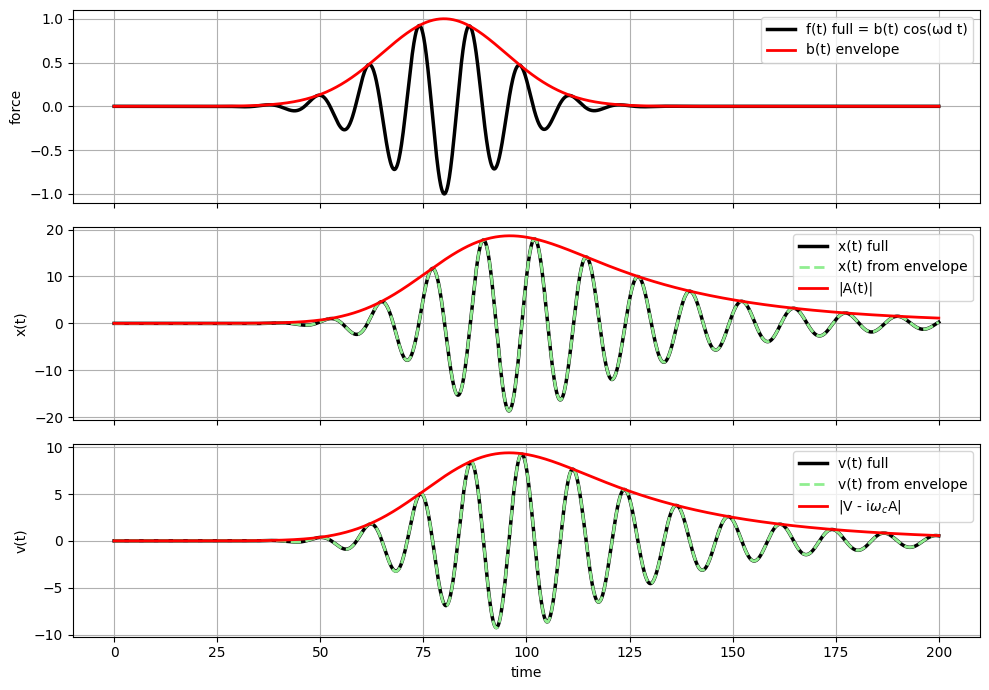

In [60]:
import numpy as np
import matplotlib.pyplot as plt

from bawosc import DrivenHarmonicOscillator

# time grid
t = np.linspace(0.0, 200.0, 2001)
dt = t[1] - t[0]

# oscillator params
omega0 = 0.5
gamma = 0.03
m = 1.0
osc = DrivenHarmonicOscillator(m=m, gamma=gamma, omega0=omega0)

# carrier + drive
omega_c = omega0
omega_d = omega0 + 0.02 * omega0
omega_d_of_t = omega_d * np.ones_like(t)

# real forcing: f(t) = b(t) cos(omega_d t)
t0 = 80.0
sigma = 15.0
b_t = np.exp(-0.5 * ((t - t0) / sigma) ** 2)
f_t = b_t * np.cos(omega_d * t)

# ----------------------------
# FULL solution
# ----------------------------
x_full = osc.solve_via_green(t, f_t)
v_full = np.gradient(x_full, dt)

# ----------------------------
# ENVELOPE solution
# IMPORTANT: use b/2 for a real cosine drive
# ----------------------------
A_t, V_t = osc.solve_envelope_green(
    t=t,
    B_of_t=b_t,         
    omega_d_of_t=omega_d_of_t,
    omega_c=omega_c,
    A0=0.0 + 0.0j,
    A1=0.0 + 0.0j,
    return_V=True,
)

# reconstruct physical signals (consistent convention)
x_rec = np.real(A_t * np.exp(-1j * omega_c * t))

# physical velocity uses (V - i ω_c A)
v_rec = np.real((V_t - 1j * omega_c * A_t) * np.exp(-1j * omega_c * t))

# ----------------------------
# Plot
# ----------------------------
fig, ax = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

ax[0].plot(t, f_t, label="f(t) full = b(t) cos(ωd t)", color='k', lw=2.5)
ax[0].plot(t, b_t, "-", label="b(t) envelope", lw=2.0, color='r')
ax[0].set_ylabel("force")
ax[0].legend(loc="upper right")

ax[1].plot(t, x_full, label="x(t) full", color='k', lw=2.5)
ax[1].plot(t, x_rec, "--", color='lightgreen', label="x(t) from envelope", lw=2)
ax[1].plot(t, np.abs(A_t), label="|A(t)|", lw=2.0, color='r')
ax[1].set_ylabel("x(t)")
ax[1].legend(loc="upper right")

ax[2].plot(t, v_full, label="v(t) full", color='k', lw=2.5)
ax[2].plot(t, v_rec, "--", color='lightgreen', label="v(t) from envelope", lw=2)
ax[2].plot(t, np.abs(V_t - 1j * omega_c * A_t), label=r"|V - i$\omega_c$A|",lw=2, color='r')
ax[2].set_ylabel("v(t)")
ax[2].set_xlabel("time")
ax[2].legend(loc="upper right")

for a in ax:
    a.grid()

plt.tight_layout()
plt.show()


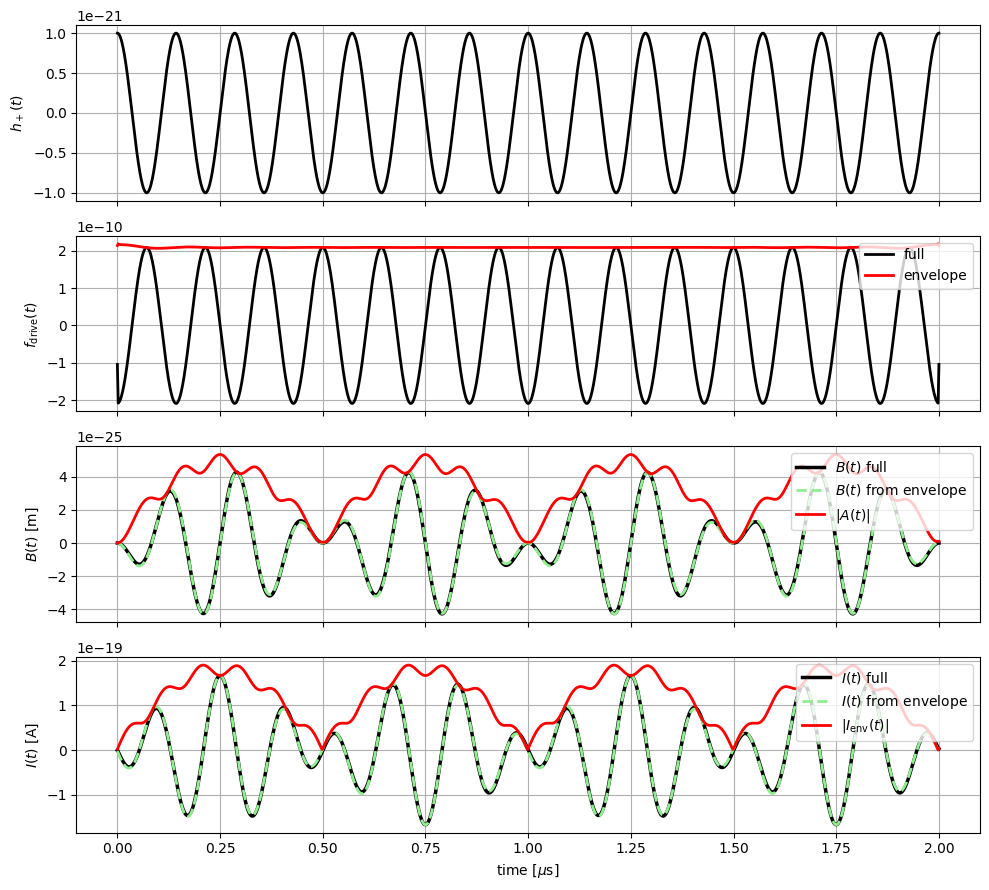

In [66]:
# ----------------------------
# Setup
# ----------------------------
t = np.linspace(0.0, 2e-6, 2001)
dt = t[1] - t[0]

baw = BAWMode(
    omega_lambda=2 * np.pi * 5e6,
    Q=1e7,
    k_lambda=1e-2,
)

# single-tone strain (example)
f_drive_hz = 5.0e6
omega_d = 2 * np.pi * (f_drive_hz + 2e6)
h_plus = 1e-21 * np.cos(omega_d * t)

# drive frequency array (works for chirps too)
omega_d_of_t = omega_d * np.ones_like(t)

# choose rotating-frame carrier
omega_c = baw.omega_lambda

# ----------------------------
# Full solution (real B, I)
# ----------------------------
B_full, Bdot_full, I_full, f_drive_full = baw.solve_current(
    t=t,
    h_plus=h_plus,
    use_green=True,   # full current via Green (or False for ODE)
)

# ----------------------------
# Envelope solution (A, I_env)
# ----------------------------
A_t, V_t, I_env, f_drive_env, F_env = baw.solve_current_envelope(
    t=t,
    h_plus=h_plus,
    omega_d_of_t=omega_d_of_t,
    omega_c=omega_c,
    use_hilbert=True,
    rescale=True,
)

# Reconstruct fast oscillating B(t), I(t) from envelopes.
# Convention used here: physical signal ≈ 2*Re[ envelope * exp(-i ω_c t) ].
B_rec = np.real(A_t * np.exp(-1j * omega_c * t))
I_rec = np.real(I_env * np.exp(-1j * omega_c * t))

# ----------------------------
# Plot: strain, force, B, I
# ----------------------------
fig, ax = plt.subplots(4, 1, figsize=(10, 9), sharex=True)

# 1) strain
ax[0].plot(t * 1e6, h_plus, lw=2, color='k')
ax[0].set_ylabel(r"$h_+(t)$")

# 2) drive force (from both paths; they should match closely)
ax[1].plot(t * 1e6, f_drive_full, label="full", lw=2, color='k')
ax[1].plot(t * 1e6, np.abs(F_env), label="envelope", lw=2, color='r')
ax[1].set_ylabel(r"$f_{\mathrm{drive}}(t)$ ")
ax[1].legend(loc="upper right")

# 3) B response: full vs reconstructed + |A| (envelope magnitude)
ax[2].plot(t * 1e6, B_full, label=r"$B(t)$ full", lw=2.5, color='k')
ax[2].plot(t * 1e6, B_rec, "--", color='lightgreen', label=r"$B(t)$ from envelope", lw=2)
ax[2].plot(t * 1e6, np.abs(A_t), label=r"$|A(t)|$", lw=2.0, color='r')
ax[2].set_ylabel(r"$B(t)$ [m]")
ax[2].legend(loc="upper right")

# 4) I response: full vs reconstructed + |I_env|
ax[3].plot(t * 1e6, I_full, label=r"$I(t)$ full", lw=2.5, color='k')
ax[3].plot(t * 1e6, I_rec, "--", color='lightgreen', label=r"$I(t)$ from envelope", lw=2)
ax[3].plot(t * 1e6, np.abs(I_env), label=r"$|I_{\mathrm{env}}(t)|$", lw=2.0, color='r')
ax[3].set_ylabel(r"$I(t)$ [A]")
ax[3].set_xlabel(r"time [$\mu$s]")
ax[3].legend(loc="upper right")


for a in ax:
    a.grid()

plt.tight_layout()
plt.show()


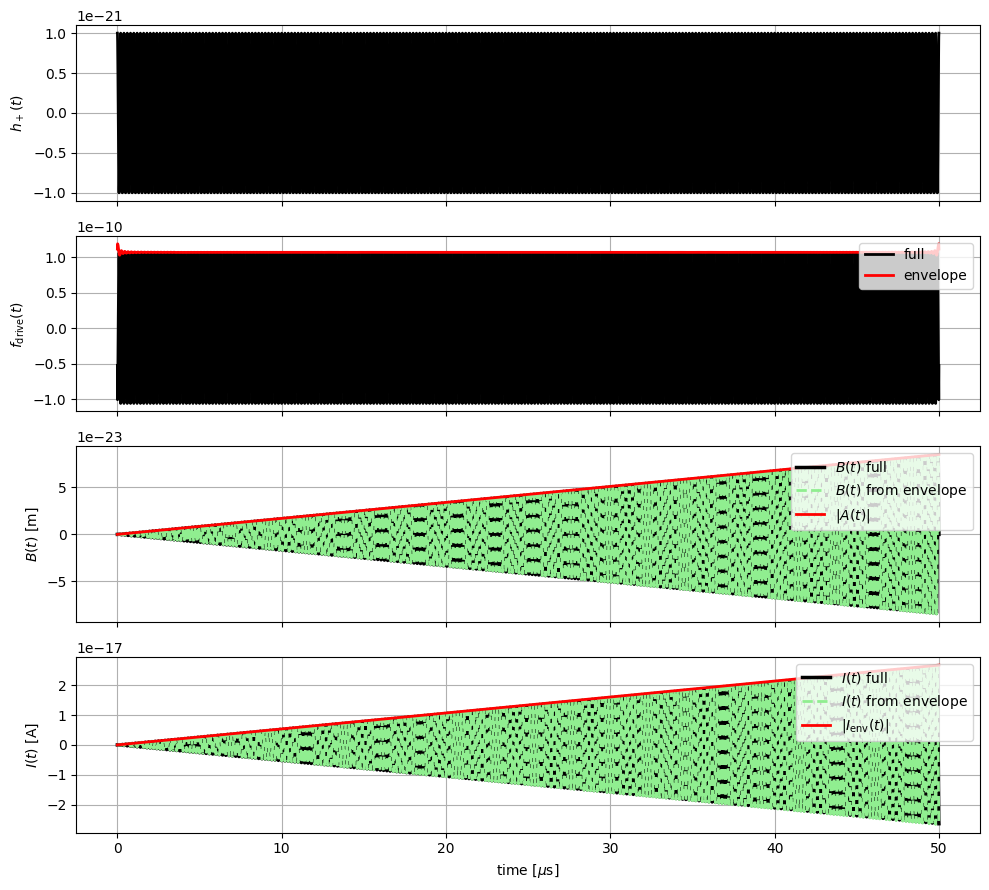

In [82]:
# ----------------------------
# Setup
# ----------------------------
t = np.linspace(0.0, 50e-6, 10001)
dt = t[1] - t[0]

baw = BAWMode(
    omega_lambda=2 * np.pi * 5e6,
    Q=1e7,
    k_lambda=1e-2,
)

# single-tone strain (example)
f_drive_hz = 5.0e6
omega_d = 2 * np.pi * (f_drive_hz)
h_plus = 1e-21 * np.cos(omega_d * t)

# drive frequency array (works for chirps too)
omega_d_of_t = omega_d * np.ones_like(t)

# choose rotating-frame carrier
omega_c = baw.omega_lambda

# ----------------------------
# Full solution (real B, I)
# ----------------------------
B_full, Bdot_full, I_full, f_drive_full = baw.solve_current(
    t=t,
    h_plus=h_plus,
    use_green=True,   # full current via Green (or False for ODE)
)

# ----------------------------
# Envelope solution (A, I_env)
# ----------------------------
A_t, V_t, I_env, f_drive_env, F_env = baw.solve_current_envelope(
    t=t,
    h_plus=h_plus,
    omega_d_of_t=omega_d_of_t,
    omega_c=omega_c,
    use_hilbert=True,
    rescale=True,
)

# Reconstruct fast oscillating B(t), I(t) from envelopes.
# Convention used here: physical signal ≈ 2*Re[ envelope * exp(-i ω_c t) ].
B_rec = np.real(A_t * np.exp(-1j * omega_c * t))
I_rec = np.real(I_env * np.exp(-1j * omega_c * t))

# ----------------------------
# Plot: strain, force, B, I
# ----------------------------
fig, ax = plt.subplots(4, 1, figsize=(10, 9), sharex=True)

# 1) strain
ax[0].plot(t * 1e6, h_plus, lw=2, color='k')
ax[0].set_ylabel(r"$h_+(t)$")

# 2) drive force (from both paths; they should match closely)
ax[1].plot(t * 1e6, f_drive_full, label="full", lw=2, color='k')
ax[1].plot(t * 1e6, np.abs(F_env), label="envelope", lw=2, color='r')
ax[1].set_ylabel(r"$f_{\mathrm{drive}}(t)$ ")
ax[1].legend(loc="upper right")

# 3) B response: full vs reconstructed + |A| (envelope magnitude)
ax[2].plot(t * 1e6, B_full, label=r"$B(t)$ full", lw=2.5, color='k')
ax[2].plot(t * 1e6, B_rec, "--", color='lightgreen', label=r"$B(t)$ from envelope", lw=2)
ax[2].plot(t * 1e6, np.abs(A_t), label=r"$|A(t)|$", lw=2.0, color='r')
ax[2].set_ylabel(r"$B(t)$ [m]")
ax[2].legend(loc="upper right")

# 4) I response: full vs reconstructed + |I_env|
ax[3].plot(t * 1e6, I_full, label=r"$I(t)$ full", lw=2.5, color='k')
ax[3].plot(t * 1e6, I_rec, "--", color='lightgreen', label=r"$I(t)$ from envelope", lw=2)
ax[3].plot(t * 1e6, np.abs(I_env), label=r"$|I_{\mathrm{env}}(t)|$", lw=2.0, color='r')
ax[3].set_ylabel(r"$I(t)$ [A]")
ax[3].set_xlabel(r"time [$\mu$s]")
ax[3].legend(loc="upper right")


for a in ax:
    a.grid()

plt.tight_layout()
plt.show()
